# Libraries

Load required libraries

In [272]:
import numpy as np
import pandas as pd
import io
#import requests
import matplotlib.pyplot as plt
import warnings
from IPython.display import Markdown as md
import seaborn as sb
#import missingno as msno


warnings.filterwarnings('ignore')
# set to show all columns
pd.set_option('display.max_columns', 55)

# Declarations

Created function moving average columns and plot graphs (helps to reuse the coide)

In [273]:
def plot_var(var='positive'):
    """
    Plots a bar chart of the given variable over the date range
    """
    assert type(var)==str, "Expected string as the variable name"

    y = df2[var]
    x = df2['date']
    plt.figure(figsize=(20,4))
    plt.title("Plot of \"{}\" for New York".format(var),fontsize=18)
    plt.plot(x,y,color='navy')
    plt.grid(False)
    plt.xticks(fontsize=14,rotation=45)
    plt.yticks(fontsize=14)
    plt.show()

def plot_hist(var='positiveIncrease'):
    """
    Plots a bar chart of the given variable over the date range
    """
    assert type(var)==str, "Expected string as the variable name"

    y = df2[var]
    plt.figure(figsize=(20,4))
    plt.title("Plot of \"{}\" for New York".format(var),fontsize=18)
    plt.hist(y,color='royalblue')
    plt.grid(False)
    plt.xticks(fontsize=14,rotation=45)
    plt.yticks(fontsize=14)
    plt.show()

def add_sevenday_newCases(df):

    df['sevenDayAvg_newCases'] = 'NA'

    for i in range(0, len(df['positiveIncrease'])):
        if i < 7:
            df['sevenDayAvg_newCases'][i] = 0
        else :
            weekly = []
            for y in range(0,7):
                weekly.append(df['positiveIncrease'][i-y])
            df['sevenDayAvg_newCases'][i] = round(sum(weekly) / 7)
    return df

# 7 days moving average for hospitalization
def add_sevenday_hospitalize(df):

    df['sevenDayAvg_hospitalize'] = 'NA'

    for i in range(0, len(df['hospitalizedIncrease'])):
        if i < 7:
            df['sevenDayAvg_hospitalize'][i] = 0
        else :
            weekly = []
            for y in range(0,7):
                weekly.append(df['hospitalizedIncrease'][i-y])
            df['sevenDayAvg_hospitalize'][i] = round(sum(weekly) / 7)
    return df

# 7 days moving average for Death
def add_sevenday_death(df):

    df['sevenDayAvg_death'] = 'NA'

    for i in range(0, len(df['deathIncrease'])):
        if i < 7:
            df['sevenDayAvg_death'][i] = 0
        else :
            weekly = []
            for y in range(0,7):
                weekly.append(df['deathIncrease'][i-y])
            df['sevenDayAvg_death'][i] = round(sum(weekly) / 7)
    return df

# 7 days moving average for Test Result
def add_sevenday_testResult(df):

    df['sevenDayAvg_testResult'] = 'NA'

    for i in range(0, len(df['totalTestResultsIncrease'])):
        if i < 7:
            df['sevenDayAvg_testResult'][i] = 0
        else :
            weekly = []
            for y in range(0,7):
                weekly.append(df['totalTestResultsIncrease'][i-y])
            df['sevenDayAvg_testResult'][i] = round(sum(weekly) / 7)
    return df

# Rejected Data Sources

## Rejected Datasource 1 (CDC)

In [274]:
%%script echo skipping # to make code not execute

from requests import request
import json
from pandas.io.json import json_normalize
import pandas as pd
import datetime


response=request(url='https://data.cdc.gov/id/vbim-akqf.json?current_status=Laboratory-confirmed%20case', method='get')
covid_records_cdc = response.json()
cdc_df = pd.DataFrame(covid_records_cdc)
format_dt = '%Y-%m-%dT%H:%M:%S.%f'
format_dt2 = '%Y-%m-%d'
# Format dates
pd.to_datetime(cdc_df['cdc_case_earliest_dt'], format=format_dt)
pd.to_datetime(cdc_df['cdc_report_dt'], format=format_dt)
pd.to_datetime(cdc_df['pos_spec_dt'], format=format_dt)
cdc_df['cdc_case_earliest_dt']=pd.to_datetime(cdc_df['cdc_case_earliest_dt'], format=format_dt2)
cdc_df['cdc_report_dt']=pd.to_datetime(cdc_df['cdc_report_dt'], format=format_dt2)
cdc_df['pos_spec_dt']=pd.to_datetime(cdc_df['pos_spec_dt'], format=format_dt2)
cdc_df.head()


Couldn't find program: 'echo'


*Since the data source doesn't provide the location of the patient, we won't be able to use it for our current
analysis*

## Rejected Datasource 2 (Johns Hopkins University)


In [275]:
%%script echo skipping # to make code not execute

# There are 424 columns present in the dataset, and the dates are present as columns. We can apply pivot on dates and
# convert columns to rows. We will delete unnecessary columns such as iso2,iso3, Country_Region, Lat, Long_, FIPS,
# Admin2, Combined_Key. Apply filter on Province_State i.e New York and timeline from March 2020 to June 2020.

# Get data
df_jhu = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_"
                     + "covid_19_time_series/time_series_covid19_confirmed_US.csv")
# View data
df_jhu.head()

df_jhu_clean = pd.DataFrame(df_jhu)
# Filter by New york state
df_jhu_clean = df_jhu_clean[df_jhu_clean['Province_State'] == 'New York']
# Timeline from March to June
df_jhu_clean = df_jhu_clean.loc[:, '3/1/20':'6/30/20']
# Check for Null value
df_jhu_clean.isnull().values.any()
# View Data
df_jhu_clean.head()

# Apply reset index and calculate new cases from confirmed cases field.

# List for Columns
column_list = df_jhu_clean.columns.tolist()
# Convert columns to rows
df_jhu_2 = pd.melt(df_jhu_clean, value_vars= column_list, value_name="Confirmed_Cases")
# Change column name to Date
df_jhu_2.rename(columns = {'variable':'Dates'}, inplace = True)
# Sum confirm cased and group by date
df_jhu_2 = pd.DataFrame(df2.groupby('Dates').sum())
# reset index
df_jhu_2.reset_index(level=None, inplace=True)
# Format Dates column
df_jhu_2['Dates'] =  pd.to_datetime(df2['Dates'], format='%m/%d/%y')
# Order by Dates
df_jhu_2.sort_values(by=['Dates'], inplace=True, ascending=True)
# View data
print(df_jhu_2.head())

# Reset Index
df_jhu_2.reset_index(level=None, drop=True, inplace=True)

# Calculate New Cases per day
def New_Cases(ds):
    df2['New_Cases'] = 'NA'

    for i in range(0, len(ds["Confirmed_Cases"])):
        if i == 0:
            ds['New_Cases'][i] = 0
        elif i > 0:
            ds['New_Cases'][i]= ds['Confirmed_Cases'][i] - ds['Confirmed_Cases'][i-1]
    return ds

# Call Function
New_Cases(df_jhu_2)

# Graph for Daily New cases
def line_graph():
    x = df_jhu_2['Dates']
    y = df_jhu_2['New_Cases']
    plt.figure(figsize=(20,4))
    plt.title("Plot of \"{}\" for New York".format("New Cases"),fontsize=18)
    plt.plot(x,y,color='navy')
    plt.grid(False)
    plt.xticks(fontsize=14,rotation=45)
    plt.yticks(fontsize=14)
    plt.show()

line_graph()

Couldn't find program: 'echo'


Since the dataset required data manipulation they are <li> Convert columns to rows <li> Calculate the confirmed cases using group by on Date column. <li> Calculate Daily new cases using the Confirmed case. <li> Confirmed cases, Death, and Recovered cases are not present in one file, from different csv file need to merge these columns 

*Opted for cleaner data set at COVID Tracking Project at Atlanta.*

# Import Data

Import data from API call and apply try catch block to handle error

In [276]:
# API Hosting Suppose to End 5/1/2021
url="https://api.covidtracking.com/v1/states/ny/daily.cs" # API Call for NY data

try:
    s = requests.get(url).content
    df = pd.read_csv(io.StringIO(s.decode('utf-8')))

    if df.values.size < 3:  # ensure DF has values (may just contain 2 error values)
        raise FileNotFoundError("No data in API")
    else:
        df.to_csv('ny_covid_data.csv', index=False)  # future proof in case api goes down
        df = pd.read_csv(io.StringIO(s.decode('utf-8')))

except FileNotFoundError as fnf_error:
    df = pd.read_csv("ny_covid_data.csv")  # read from most recently fetched data
except: # catch any other unexpected error
    df = pd.read_csv("ny_covid_data.csv")

# Data Transformation

We transform the date column to a datetime format, so instead of for example appearing as '20210306',  it will now be '2020-03-06'.

Lastly we apply a date filter to only include 2020 data.

In [277]:
# Format dates
df['date'] =  pd.to_datetime(df['date'], format='%Y%m%d') 

# Impute NaN values
# df.fillna(value=-1, inplace=True)

# apply filter on date
# df = df[df['date'] <= '2020-12-31']


# NYC Holiday calendar dataset for 2020


In [278]:
# 3/20/21 A.C. commented below, we don't need Holiday and date feature

# holiday_data = {'date': ['2020-01-01','2020-01-20','2020-02-17','2020-05-25','2020-06-30','2020-09-07','2020-10-12',
# '2020-11-03','2020-11-11','2020-11-26','2020-12-25'],
# 		'Holiday': ['New Year Day','Martin Luther King Jr. Day', 'Presidents Day', 'Memorial Day',
# 		'Independence Day(Observed)','Labor Day','Columbus Day','Election Day','Veterans Day','Thanksgiving day',
# 		'Christmas Day' ],
#         'is_holiday':['1','1','1','1','1','1','1','1','1','1','1'],
# 		'is_long_weekend':['0','1','1','1','1','1','1','0','0','1','1']
# 		}

# calendar_df = pd.DataFrame (holiday_data, columns = ['date','Holiday','is_holiday','is_long_weekend'])

holiday_data = {'date': ['2020-01-01','2020-01-20','2020-02-17','2020-05-25','2020-06-30','2020-09-07','2020-10-12',
                         '2020-11-03','2020-11-11','2020-11-26','2020-12-25'],
        'is_holiday':[1,1,1,1,1,1,1,1,1,1,1],  # edit 4/6 A.C. should be numerics
		'is_long_weekend':[0,1,1,1,1,1,1,0,0,1,1] # edit 4/6 A.C. should be numerics
                }

calendar_df = pd.DataFrame (holiday_data, columns = ['date', 'is_holiday','is_long_weekend'])

calendar_df['date'] =  pd.to_datetime(calendar_df['date'], format='%Y-%m-%d')  
df2 = df.set_index('date').join(calendar_df.set_index('date'))

# Fill remaining values with 0s for Non-Holiday times
df2['is_holiday'].fillna(0,inplace=True)
df2['is_long_weekend'].fillna(0, inplace=True)

df2.head()

,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,hospitalizedDischarged,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,deathConfirmed,deathProbable,...,positiveTestsAntibody,negativeTestsAntibody,totalTestsPeopleAntibody,positiveTestsPeopleAntibody,negativeTestsPeopleAntibody,totalTestsPeopleAntigen,positiveTestsPeopleAntigen,totalTestsAntigen,positiveTestsAntigen,fips,positiveIncrease,negativeIncrease,total,totalTestResultsIncrease,posNeg,dataQualityGrade,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade,is_holiday,is_long_weekend
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-06,NY,1674380,NaN,NaN,NaN,totalTestEncountersViral,39467332,4954.0,89995.0,1012.0,NaN,694.0,NaN,NaN,3/5/2021 14:00,2021-03-05T14:00:00Z,03/05 09:00,38970.0,89995.0,149481.0,2021-03-05T14:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,7647,0,1674380,273132,1674380,NaN,79,0,cb77d2163ba007105af830c9bb4de5a0bfd96859,0,0,0,0,0,NaN,0.0,0.0
2021-03-05,NY,1666733,NaN,NaN,NaN,totalTestEncountersViral,39194200,5034.0,89995.0,1030.0,NaN,700.0,NaN,NaN,3/4/2021 14:00,2021-03-04T14:00:00Z,03/04 09:00,38891.0,89995.0,148923.0,2021-03-04T14:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,8956,0,1666733,296935,1666733,NaN,95,0,3b2002d4b127ba2cd97aa9696daec74f3c1c5315,0,0,0,0,0,NaN,0.0,0.0
2021-03-04,NY,1657777,NaN,NaN,NaN,totalTestEncountersViral,38897265,5177.0,89995.0,1043.0,NaN,712.0,NaN,NaN,3/3/2021 14:00,2021-03-03T14:00:00Z,03/03 09:00,38796.0,89995.0,148355.0,2021-03-03T14:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,7593,0,1657777,270089,1657777,NaN,61,0,fd521527694c269fc2d5acae5f6aedff4c317f28,0,0,0,0,0,NaN,0.0,0.0
2021-03-03,NY,1650184,NaN,NaN,NaN,totalTestEncountersViral,38627176,5323.0,89995.0,1047.0,NaN,735.0,NaN,NaN,3/2/2021 14:00,2021-03-02T14:00:00Z,03/02 09:00,38735.0,89995.0,147730.0,2021-03-02T14:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,7704,0,1650184,218069,1650184,NaN,75,0,9e1d88ac35d74dc7969fd77d287ae42d5721f5f8,0,0,0,0,0,NaN,0.0,0.0
2021-03-02,NY,1642480,NaN,NaN,NaN,totalTestEncountersViral,38409107,5369.0,89995.0,1076.0,NaN,747.0,NaN,NaN,3/1/2021 14:00,2021-03-01T14:00:00Z,03/01 09:00,38660.0,89995.0,147149.0,2021-03-01T14:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,5800,0,1642480,128034,1642480,NaN,83,0,5267dbc1d00d949273c1b47cbb05e07feb477428,0,0,0,0,0,NaN,0.0,0.0


## MTA Ridership Data for 2020

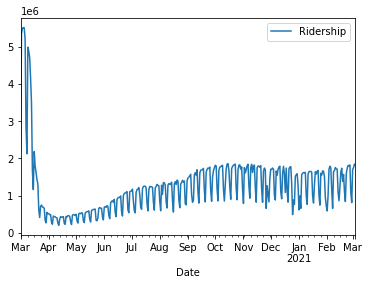

In [279]:
mta_df = pd.read_csv('MTA_data.csv',index_col=[0], parse_dates=[0])

mta_df = mta_df[[ 'Subways: Total Estimated Ridership']] 
 
mta_df['Subways: Total Estimated Ridership'] = pd.to_numeric(mta_df['Subways: Total Estimated Ridership'])

mta_df.columns = ['Ridership']
mta_df.plot()

# A.C. edit 3/20/2021, must set to variable, function alone doesn't update reference
df2 = df2.join(mta_df)

# EDA

There are columns that don't have a significant impact to our analysis such:

* date checked
* date modified
* hash (identifier)
* fips (state code, we are only concerned with NY)
* state (again we are only doing NY, so we won't need this column)
* total test resource source (single value only that is a string)

These columns we want to exclude.

In [280]:
# A.C. edit 4/6 adding hash and fip feature since it's meaningless
df2.drop(['dateChecked', 'dateModified', 'hash', 'fips', 'state', 'totalTestResultsSource'],axis=1,inplace=True)

We set a threshold of to tolerate up to 90% of values being NA per column. If a column contains more than 90% of NA
values we drop it.

In [281]:
df2.info
limitPer = len(df2) * .99

df2 = df2.dropna(thresh=limitPer, axis=1)


There are also many features that just have zeros in them, we want to exclude that in our set as well.

In [282]:
df2 = df2.loc[:, (df2 != 0).any(axis=0)]

We ended up excluding 20+ columns that just contained NA values, 2 columns that didn't have significant information
(date modified and date checked), and 6 columns that only contained zeros.

In [283]:
# set date index in asending order
df2.sort_values(by=['date'], inplace=True, ascending=True)


# add sevendays column to dataset
add_sevenday_newCases(df2)
add_sevenday_hospitalize(df2)
add_sevenday_death(df2)
add_sevenday_testResult(df2)

# change type of column object to numeric
df2[['sevenDayAvg_newCases', 'sevenDayAvg_hospitalize', 'sevenDayAvg_death',  
    'sevenDayAvg_testResult']] = df2[['sevenDayAvg_newCases', 
                                     'sevenDayAvg_hospitalize', 'sevenDayAvg_death',  
                                     'sevenDayAvg_testResult']].apply(pd.to_numeric)


Set Date index in asdending order then added 4 new columns in to the datset, they are sevenDayAvg_newCases, sevenDayAvg_hospitalize, sevenDayAvg_death, sevenDayAvg_testResult. Change the datatype of newly added columns from object to numeric.

## Backup Final Dataset

Exported a csv file named final-ny-data.csv and stored in Git repo. 

In [284]:

df2['date']=df2.index

df2 = df2.reset_index(drop=True)

df2.to_csv('full-year-ny-data.csv', index=False)

## Feature Plots
In this first plot we can see the daily number of positive cases in NY:

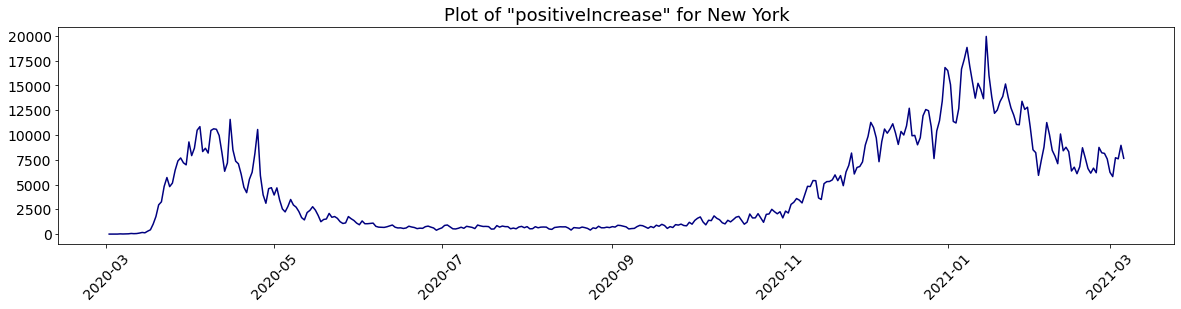

In total there were 1,674,380 positive cases in New York during that time range.

In [285]:
plot_var('positiveIncrease')

totalCases = "{:,.0f}".format(df2['positiveIncrease'].sum())

md(f"In total there were {totalCases} positive cases in New York during that time range.")

The following plots also show the increases in hospitalizations, deaths, and the total amount of test results.

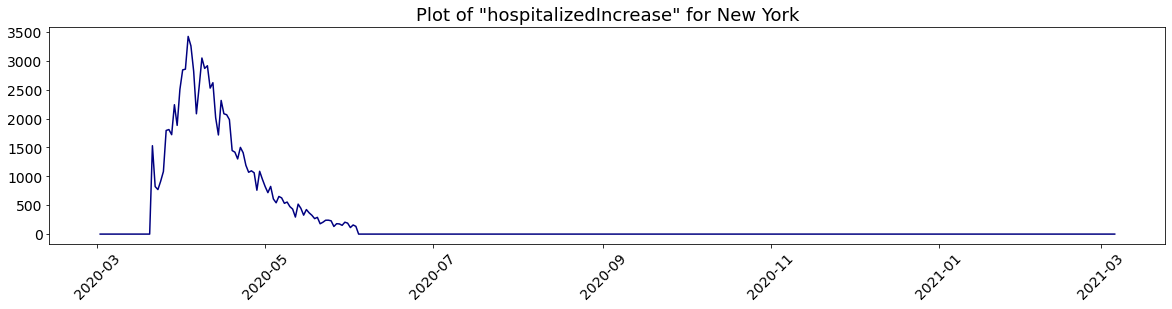

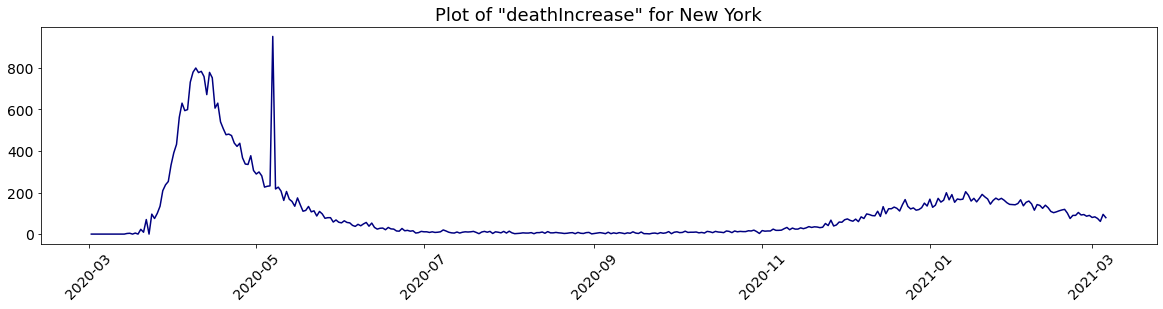

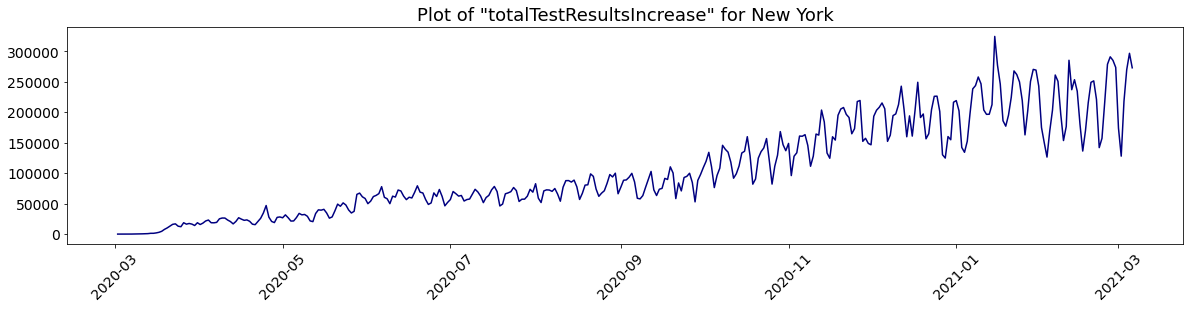

In [286]:
plot_var('hospitalizedIncrease')

plot_var('deathIncrease')

plot_var('totalTestResultsIncrease')

pd.set_option('display.max_columns', 56)

# 7 days moving average for positiveIncrease
df2.sort_values(by=['date'], inplace=True, ascending=True)

# reset index
# A.C. edit 3/20/2021 commented below, reset not needed
# df2.reset_index(level=0, inplace=True)

## Plots on 7-Day Moving Averages

Below plots shows the 7-day moving averages of new cases, hospitalization, death and test result.

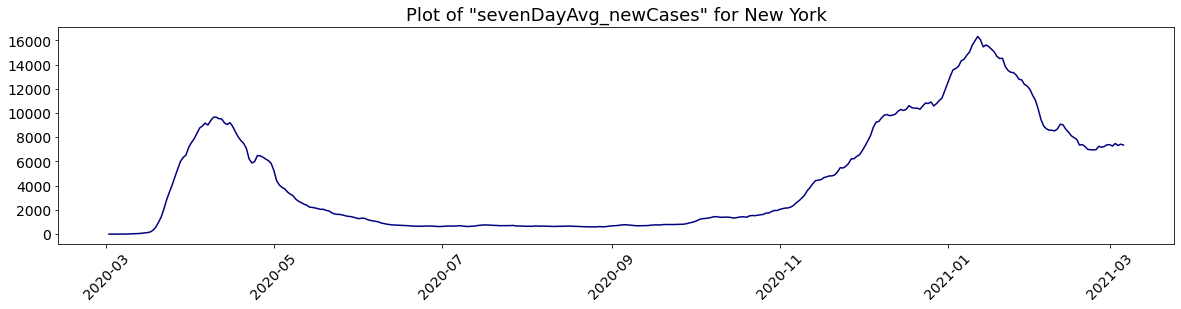

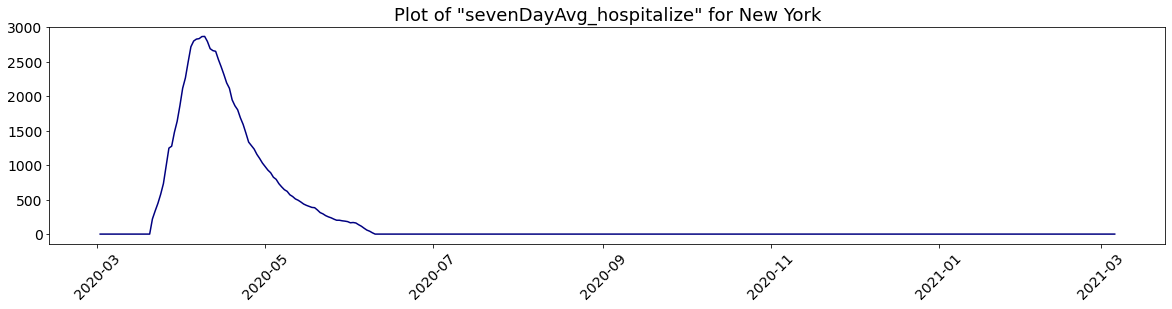

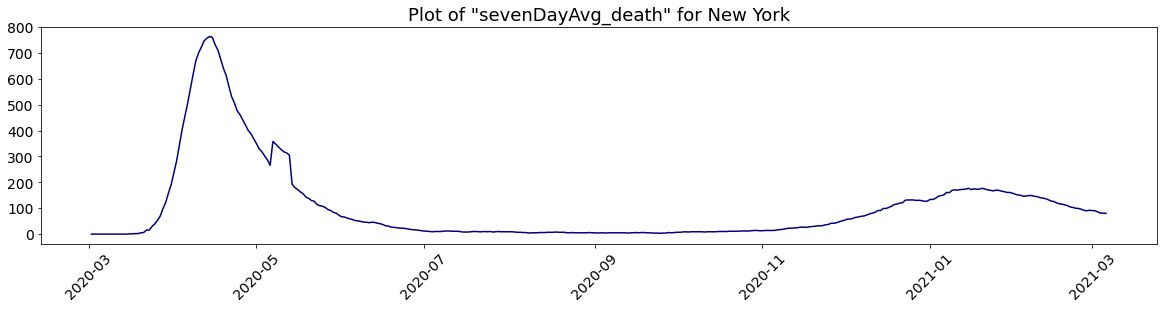

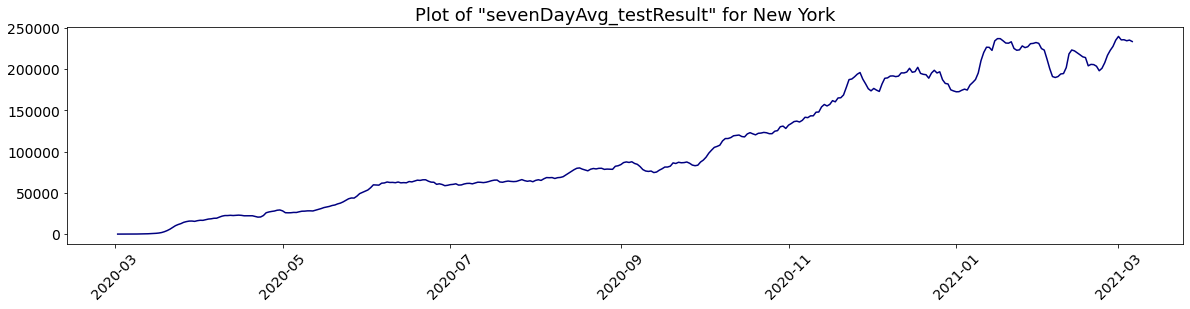

In [287]:
plot_var('sevenDayAvg_newCases')
plot_var('sevenDayAvg_hospitalize')
plot_var('sevenDayAvg_death')
plot_var('sevenDayAvg_testResult')

## Histogram Plots

Histogram shows the distribution of new cases,  hospitalization, death and test result along with 7-days moving average measures.

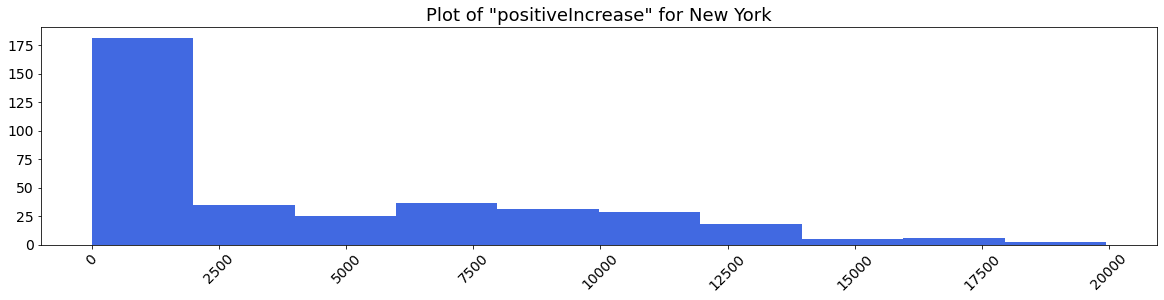

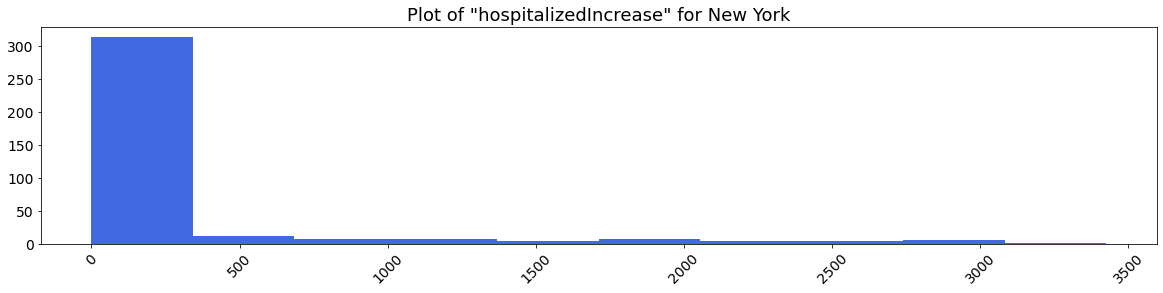

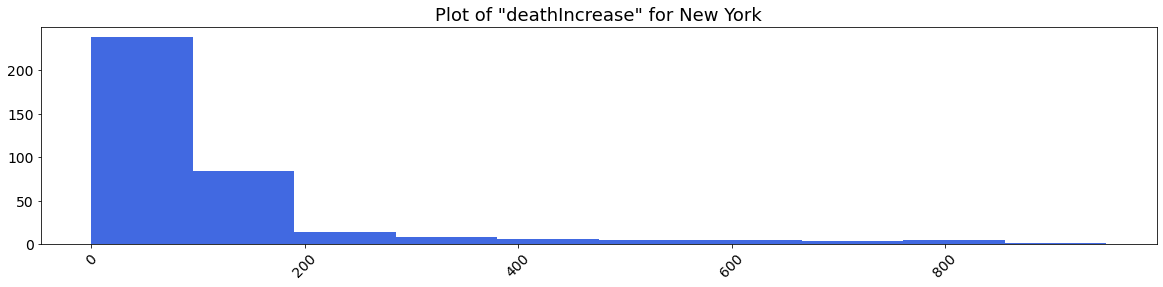

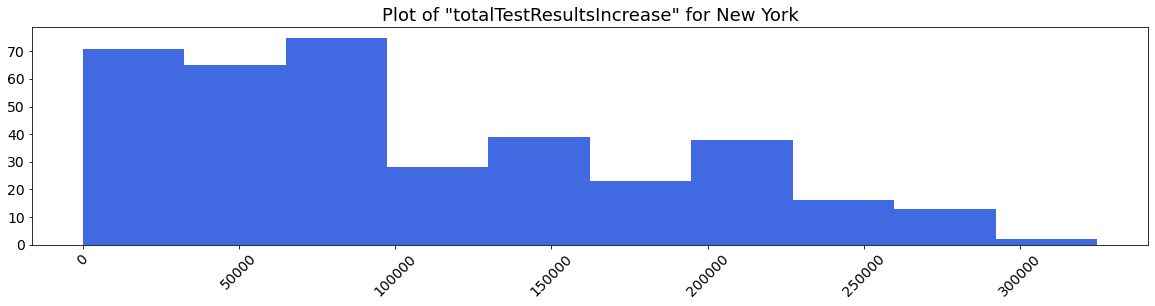

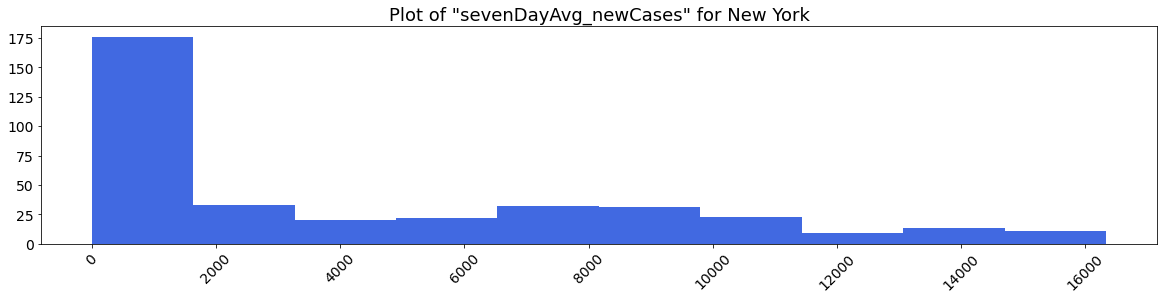

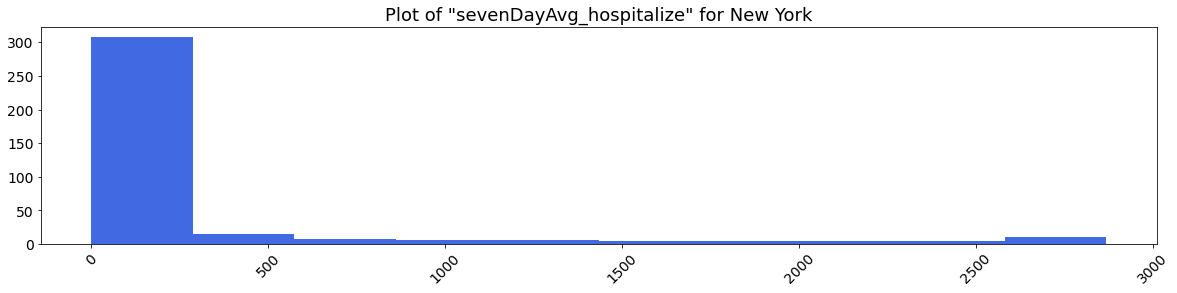

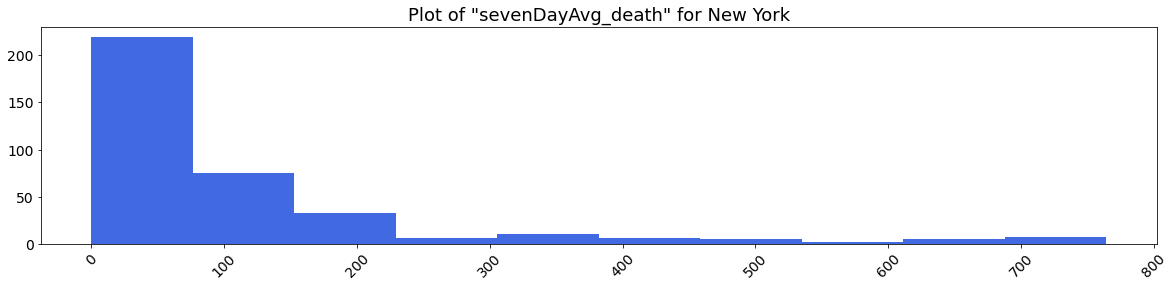

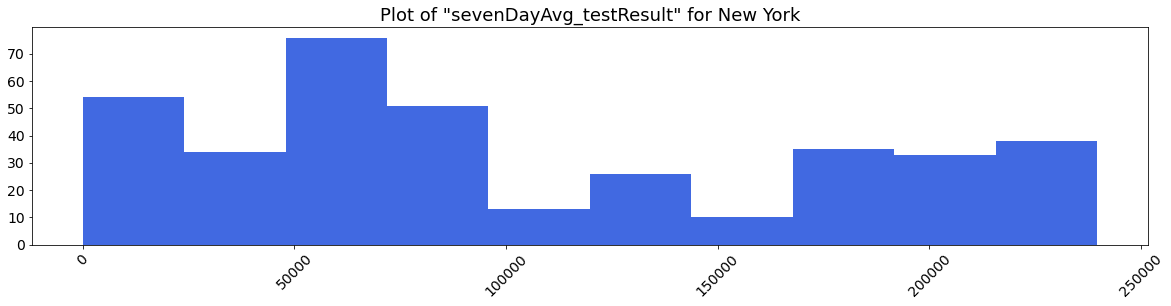

In [288]:
plot_hist('positiveIncrease')

plot_hist('hospitalizedIncrease')

plot_hist('deathIncrease')

plot_hist('totalTestResultsIncrease')

plot_hist('sevenDayAvg_newCases')

plot_hist('sevenDayAvg_hospitalize')

plot_hist('sevenDayAvg_death')

plot_hist('sevenDayAvg_testResult')

## Correlation Matrix

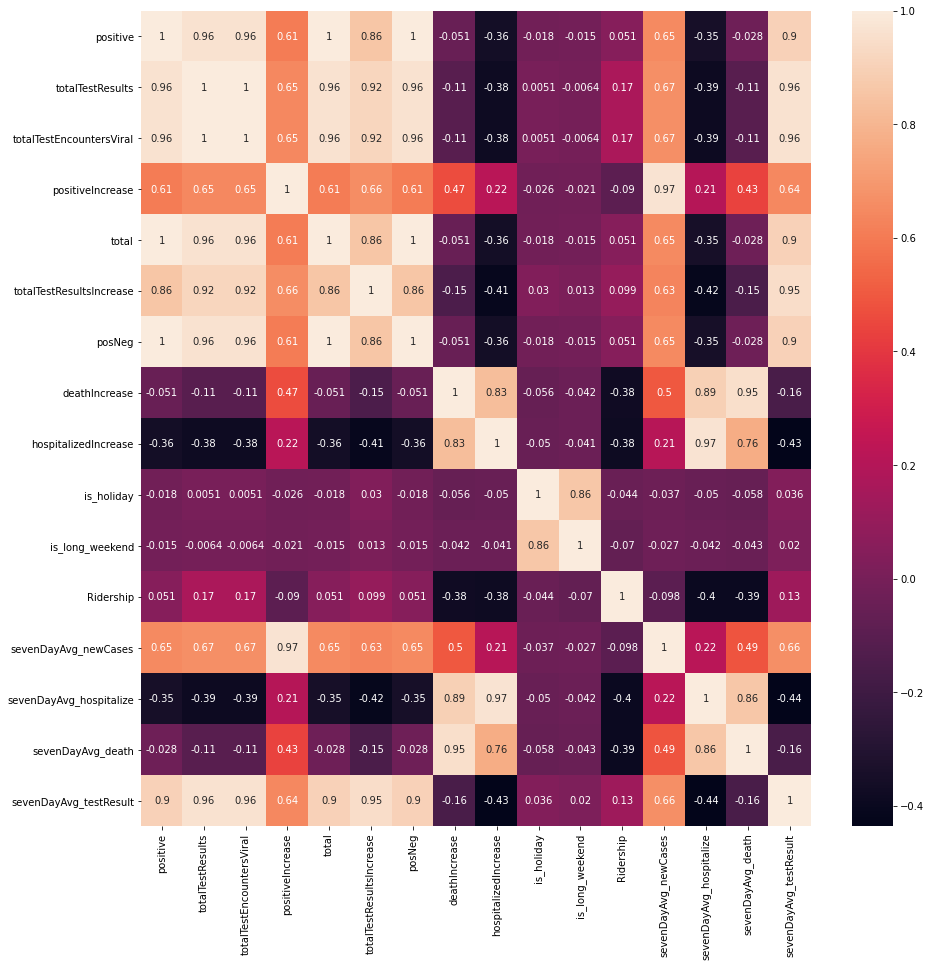

In [289]:
corrMatrix = df2.corr()
fig, ax = plt.subplots(figsize=(15,15))
sb.heatmap(corrMatrix, annot=True, ax = ax)
plt.show()

It's plain to see that death increases are positively correlated with hospitalizations and positive cases. It would also
make sense that there would exist a negative correlations between deaths and total tests done, as the more informed the
population is the better course of action they can take based on their status results.


## Scatter Matrix Plot

A scatter plot matrix is a grid (or matrix) of scatter plots used to visualize bivariate relationships between combinations of variables. The plot shows distribution and co-relation of the of sevenDayAvg_newCases, sevenDayAvg_hospitalize, sevenDayAvg_death, sevenDayAvg_testResult.

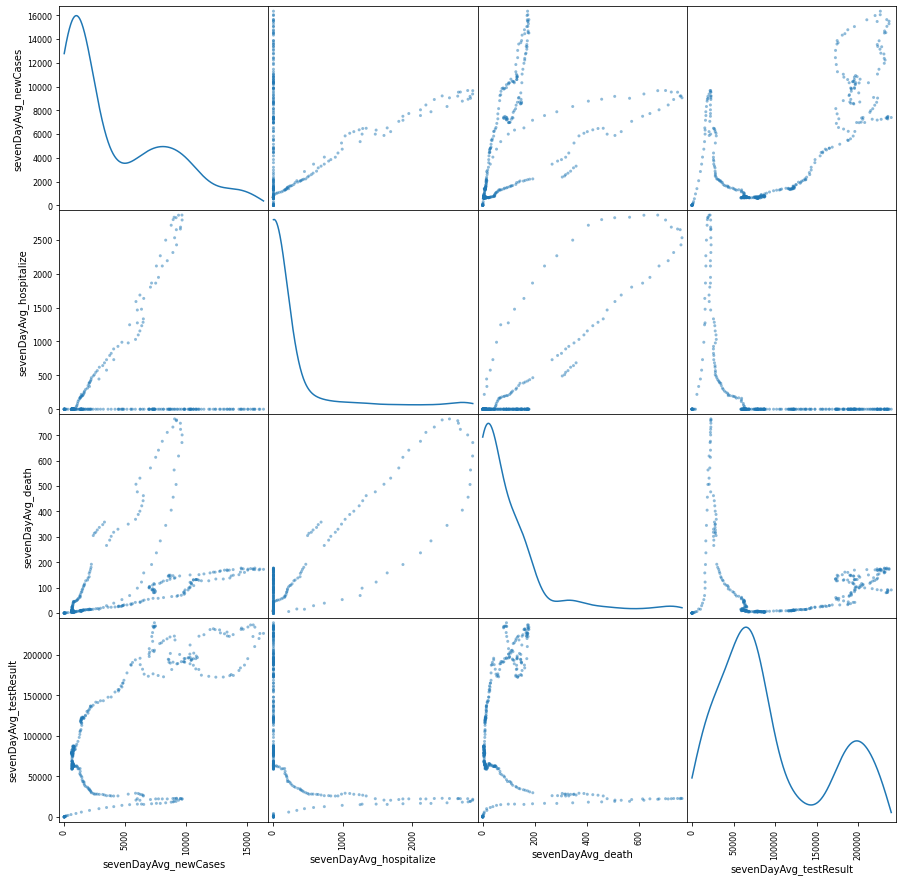

In [290]:
from pandas.plotting import scatter_matrix
df3 = df2[['sevenDayAvg_newCases', 'sevenDayAvg_hospitalize', 'sevenDayAvg_death',  'sevenDayAvg_testResult']]
scatter_matrix(df3, figsize=(15,15), diagonal = "kde")
plt.show()

Above plot shows positive co-relation between sevenDayAvg_newCases with sevenDayAvg_hospitalize 


# Final State of data

In [291]:
df2.info


<bound method DataFrame.info of      positive  totalTestResults  totalTestEncountersViral  positiveIncrease  \
0           0                 0                         0                 0   
1           1                 1                         1                 1   
2           1                10                        10                 0   
3           3                30                        30                 2   
4          25               122                       122                22   
..        ...               ...                       ...               ...   
365   1642480          38409107                  38409107              5800   
366   1650184          38627176                  38627176              7704   
367   1657777          38897265                  38897265              7593   
368   1666733          39194200                  39194200              8956   
369   1674380          39467332                  39467332              7647   

       total  total

In [292]:
df2.dtypes
# Commented below not being used.
# from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt





positive                             int64
totalTestResults                     int64
totalTestEncountersViral             int64
positiveIncrease                     int64
total                                int64
totalTestResultsIncrease             int64
posNeg                               int64
deathIncrease                        int64
hospitalizedIncrease                 int64
is_holiday                         float64
is_long_weekend                    float64
Ridership                          float64
sevenDayAvg_newCases                 int64
sevenDayAvg_hospitalize              int64
sevenDayAvg_death                    int64
sevenDayAvg_testResult               int64
date                        datetime64[ns]
dtype: object